# General Type{T} Parareal Algorithm for system of ODE's

In [1]:
# Copied the Lorenz function from Dr. Ben's parareal code
function Lorenz(::Type{T}, t, u) where T<:AbstractFloat
    
    σ = 10 # parameters for Lorenz
    ρ = 28 
    β = 8/3
    y1::T = σ*(u[2] .- u[1])
    y2::T = ρ*u[1] .- u[2] .-u[1]*u[3]
    y3::T = u[1]*u[2] .- β*u[3]
   
    return [y1; y2; y3]
end

Lorenz (generic function with 1 method)

In [2]:
# Forward Euler Method
using LinearAlgebra
function FE(::Type{T}, f, a, b, u0, N) where T<:AbstractFloat
    ndf = length(u0)
    u = Matrix{T}(undef, ndf, N+1)
    dt = (b-a)/N
    t = Vector(range(a, b, length=N+1))
    u[:, 1] = u0
    for i in 1:N
        u[:, i+1] = u[:, i] .+ dt * Lorenz(T, t[i], u[:, i])
    end
    return t, u
end

FE (generic function with 1 method)

In [34]:
# Parareal method
function parareal(::Type{T}, a, b, u0, N, F, G, K) where T<:AbstractFloat
    # a= start time value (t0)
    # b= End time value (tend)
    # N= Number of Subinterval
    # u0=initial Solution
    # F= Fine Solver
    # G= Coarse Solver
    # K= Parareal iteration
    ndf=length(u0)
    tval=Vector(range(a, b, N+1))
    # Storing Fine Solution on each time step for comparison
    Ufine=Matrix{T}(undef, ndf, N+1)
    Ufine[:, 1] = u0
    for i in 1:N
        Ufine[:, i+1] = F(T, tval[i], tval[i+1], Ufine[:, i])
    end
    # Initializing Uk
    #Uk::Vector{Vector{T}}=[zeros(ndf, N+1) for k in 1:K+1]
    Uk=Matrix{T}[zeros(ndf, N+1) for k in 1:K+1]
    #Storing the initial solution
    for k in 1:K+1
        Uk[k][:,1] = u0
    end
    # Parareal Initialization
    for j in 1:N
        #Uk[1][:,j+1] = G(T, tval[j], tval[j+1], Uk[1][:, j])
        Uk[1][:,j+1] .= 10.0 # May take random initial guess
    end
    
    #δUk=Matrix{T}[zeros(ndf, N+1) for k in 1:K+1]
    # Parareal loop
    for k in 1:K
        for i in 1:N
            #δUk[k][:, i]=Uk[k+1][:,i] - Uk[k][:,i]
            Fk = F(T, tval[i], tval[i+1], Uk[k][:, i])
            Gk0 = G(T, tval[i], tval[i+1], Uk[k][:, i])
            Gk1 = G(T, tval[i], tval[i+1], Uk[k+1][:, i])
            Uk[k+1][:, i+1] = Fk + Gk1-Gk0
        end
    end
    
    return Uk, Ufine, tval
  
end

parareal (generic function with 1 method)

In [4]:
function Fs(::Type{T},a, b, u0) where T<:AbstractFloat
    t, u = FE(T, Lorenz, a, b, u0, nF)
    return u[:, end]
end

Fs (generic function with 1 method)

In [5]:
function Gs(::Type{T},a, b, u0) where T<:AbstractFloat
    t, u = FE(T, Lorenz, a, b, u0, nG)
    return u[:, end]
end

Gs (generic function with 1 method)

# Convergence analysis of Double Precision Parareal

In [ ]:
# Convergence Analysis in uniform double precision
a=0
b=1
u0=Vector{Float64}([20; -5; 5])

nF=1000 # Fine grid
nG=15 # Coarse grid
K=100 # Number of iteration
p = 3
N = zeros(p)
for i in 1:p
    N[i] = Int(floor(10^(i+2)))
end

err_double=zeros(p, K+1)
# Parareal Solution
for i in 1:p
    Uk, Ufine, tval = parareal(Float64, a, b, u0, convert(Int, N[i]), Fs, Gs, K)

    # stroing errors
    
    for k in 1:K+1
        err_double[i, k]=norm(Uk[k][:, :] - Ufine)
    end
end

using Plots
plot(err_double[1,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^3",title="Double precision parareal")
for j in 2:p
    plot!(err_double[j,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^$(j+2)")
end
display(plot!(legend=:topright))

# Convergence Analysis Of Parareal in Single Precision

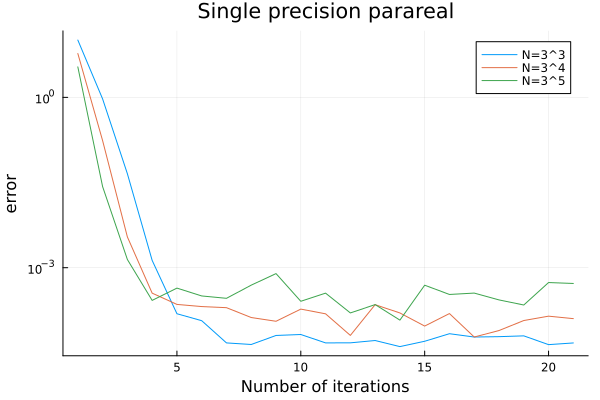

In [31]:
# Convergence Analysis in uniform single precision
a=0
b=1
u0=[20; -5; 5]

#exact=exp.((t.^3)/3)


nF=1000 # Fine grid
nG=15 # Coarse grid
K=20 # Number of iteration
p = 3
N = zeros(p)
for i in 1:p
    N[i] = Int(floor(3^(i+2)))
end

err_single=zeros(p, K+1)
# Parareal Solution
for i in 1:p
    Uk, Ufine, tval = parareal(Float32, a, b, u0, convert(Int, N[i]), Fs, Gs, K)

    # stroing errors
    
    for k in 1:K+1
        err_single[i, k]=norm(Uk[k][:, :] - Ufine)
    end
end

using Plots
plot(err_single[1,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^3", title="Single precision parareal")
for j in 2:p
    plot!(err_single[j,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^$(j+2)")
end
display(plot!(legend=:topright))

# Convergence Analysis Of Parareal in Half Precision

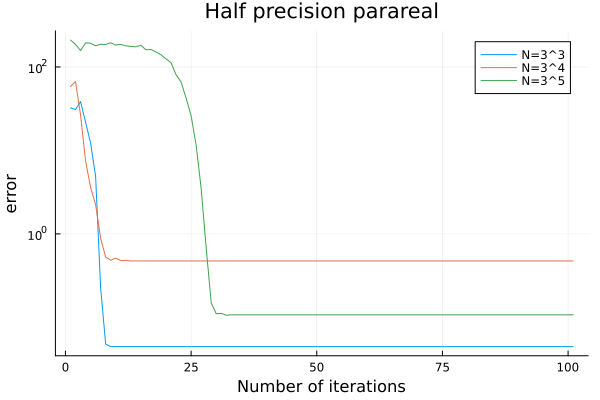

In [27]:
# Convergence Analysis in uniform Half precision
a=0
b=1
u0=[20; -5; 5]

#exact=exp.((t.^3)/3)


nF=1000 # Fine grid
nG=15 # Coarse grid
K=100 # Number of iteration
p = 3
N = zeros(p)
for i in 1:p
    N[i] = Int(floor(2^(i+2)))
end

err_half=zeros(p, K+1)
# Parareal Solution
for i in 1:p
    Uk, Ufine, tval = parareal(Float16, a, b, u0, convert(Int, N[i]), Fs, Gs, K)

    # stroing errors
    
    for k in 1:K+1
        err_half[i, k]=norm(Uk[k][:, :] - Ufine)
    end
end

using Plots
plot(err_half[1,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^3", title="Half precision parareal")
for j in 2:p
    plot!(err_half[j,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^$(j+2)")
end
display(plot!(legend=:topright))

# Parareal in Mixed Precision (Single and Double)

In [9]:
# Mixed(Single and Double) Parareal method
function sdparareal(::Type{T}, a, b, u0, N, F, G, K) where T<:AbstractFloat
    # a= start time value (t0)
    # b= End time value (tend)
    # N= Number of Subinterval
    # u0=initial Solution
    # F= Fine Solver
    # G= Coarse Solver
    # K= Parareal iteration
    ndf=length(u0)
    tval=Vector(range(a, b, N+1))
    # Storing Fine Solution on each time step for comparison
    Ufine=Matrix{Float64}(undef, ndf, N+1)
    Ufine[:, 1] = u0
    for i in 1:N
        Ufine[:, i+1] = F(Float64, tval[i], tval[i+1], Ufine[:, i])
    end
    # Initializing Uk
    #Uk::Vector{Vector{T}}=[zeros(ndf, N+1) for k in 1:K+1]
    Uk=Matrix{Float64}[zeros(ndf, N+1) for k in 1:K+1]
    #Storing the initial solution
    for k in 1:K+1
        Uk[k][:,1] = u0
    end
    # Parareal Initialization
    for j in 1:N
        Uk[1][:,j+1] = G(Float32, tval[j], tval[j+1], Uk[1][:, j])
        #Uk[1][:,j+1]= 10.0 # May take random initial guess
    end
    
    #δUk=Matrix{T}[zeros(ndf, N+1) for k in 1:K+1]
    # Parareal loop
    for k in 1:K
        for i in 1:N
            #δUk[k][:, i]=Uk[k+1][:,i] - Uk[k][:,i]
            Fk = F(Float64, tval[i], tval[i+1], Uk[k][:, i])
            Gk0 = G(Float32, tval[i], tval[i+1], Uk[k][:, i])
            Gk1 = G(Float32, tval[i], tval[i+1], Uk[k+1][:, i])
            Uk[k+1][:, i+1] = Fk + Gk1 - Gk0
        end
    end
    
    return Uk, Ufine, tval
  
end

sdparareal (generic function with 1 method)

In [10]:
function sdFs(::Type{T},a, b, u0) where T<:AbstractFloat
    t, u = FE(Float64, Lorenz, a, b, u0, nF)
    return u[:, end]
end

sdFs (generic function with 1 method)

In [11]:
function sdGs(::Type{T},a, b, u0) where T<:AbstractFloat
    t, u = FE(Float32, Lorenz, a, b, u0, nF)
    return u[:, end]
end

sdGs (generic function with 1 method)

# Convergence Analysis of Mixed(Single and Double) Precision Parareal

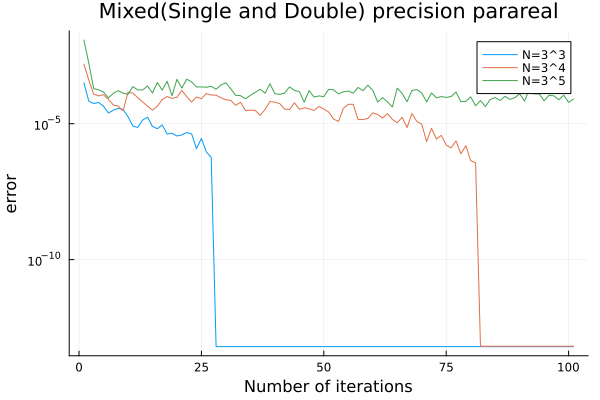

In [28]:
# Convergence Analysis in uniform Mixed (Single and double) precision
a=0
b=1
u0=[20; -5; 5]

nF=1000 # Fine grid
nG=15 # Coarse grid
K=100 # Number of iteration
p = 3
N = zeros(p)
for i in 1:p
    N[i] = Int(floor(3^(i+2)))
end

err_msd=zeros(p, K+1)
# Parareal Solution
for i in 1:p
    Uk, Ufine, tval = sdparareal(Float64, a, b, u0, convert(Int, N[i]), sdFs, sdGs, K)

    # stroing errors
    
    for k in 1:K+1
        err_msd[i, k]=norm(Uk[k][:, :] - Ufine)
    end
end

using Plots
plot(err_msd[1,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^3", title="Mixed(Single and Double) precision parareal")
for j in 2:p
    plot!(err_msd[j,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^$(j+2)")
end
display(plot!(legend=:topright))

# Parareal in Mixed (Half and Double) Precision

In [14]:
# Mixed(Double and Double) Parareal method
function hdparareal(::Type{T}, a, b, u0, N, F, G, K) where T<:AbstractFloat
    # a= start time value (t0)
    # b= End time value (tend)
    # N= Number of Subinterval
    # u0=initial Solution
    # F= Fine Solver
    # G= Coarse Solver
    # K= Parareal iteration
    ndf=length(u0)
    tval=Vector(range(a, b, N+1))
    # Storing Fine Solution on each time step for comparison
    Ufine=Matrix{Float64}(undef, ndf, N+1)
    Ufine[:, 1] = u0
    for i in 1:N
        Ufine[:, i+1] = F(Float64, tval[i], tval[i+1], Ufine[:, i])
    end
    # Initializing Uk
    #Uk::Vector{Vector{T}}=[zeros(ndf, N+1) for k in 1:K+1]
    Uk=Matrix{Float64}[zeros(ndf, N+1) for k in 1:K+1]
    #Storing the initial solution
    for k in 1:K+1
        Uk[k][:,1] = u0
    end
    # Parareal Initialization
    for j in 1:N
        Uk[1][:,j+1] = G(Float16, tval[j], tval[j+1], Uk[1][:, j])
        #Uk[1][:,j+1]= 10.0 # May take random initial guess
    end
    
    #δUk=Matrix{T}[zeros(ndf, N+1) for k in 1:K+1]
    # Parareal loop
    for k in 1:K
        for i in 1:N
            #δUk[k][:, i]=Uk[k+1][:,i] - Uk[k][:,i]
            Fk = F(Float64, tval[i], tval[i+1], Uk[k][:, i])
            Gk0 = G(Float16, tval[i], tval[i+1], Uk[k][:, i])
            Gk1 = G(Float16, tval[i], tval[i+1], Uk[k+1][:, i])
            Uk[k+1][:, i+1] = Fk + Gk1 - Gk0
        end
    end
    
    return Uk, Ufine, tval
  
end

hdparareal (generic function with 1 method)

In [15]:
function hdFs(::Type{T},a, b, u0) where T<:AbstractFloat
    t, u = FE(Float64, Lorenz, a, b, u0, nF)
    return u[:, end]
end

hdFs (generic function with 1 method)

In [16]:
function hdGs(::Type{T},a, b, u0) where T<:AbstractFloat
    t, u = FE(Float16, Lorenz, a, b, u0, nF)
    return u[:, end]
end

hdGs (generic function with 1 method)

# Convergence Analysis of Mixed (Hald and Double) Precision Parareal

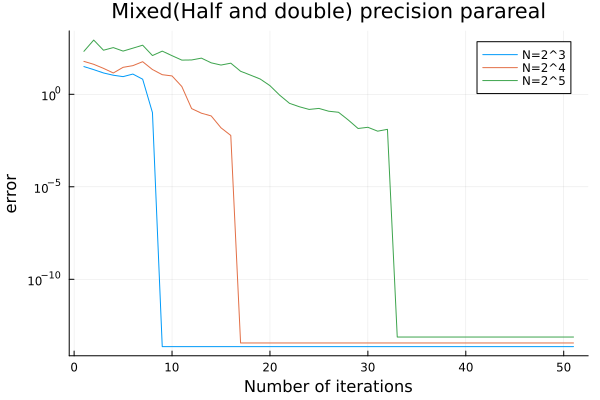

In [30]:
# Convergence Analysis in Mixed (Half and double) precision
a=0
b=1
u0=[20; -5; 5]

nF=1000 # Fine grid
nG=15 # Coarse grid
K=50 # Number of iteration
p = 3
N = zeros(p)
for i in 1:p
    N[i] = Int(floor(2^(i+2)))
end

err_mhd=zeros(p, K+1)
# Parareal Solution
for i in 1:p
    Uk, Ufine, tval = hdparareal(Float64, a, b, u0, convert(Int, N[i]), hdFs, hdGs, K)

    # stroing errors
    
    for k in 1:K+1
        err_mhd[i, k]=norm(Uk[k][:, :] - Ufine)
    end
end

using Plots
plot(err_mhd[1,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=2^3", title="Mixed(Half and double) precision parareal")
for j in 2:p
    plot!(err_mhd[j,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=2^$(j+2)")
end
display(plot!(legend=:topright))